# Imports

In [1]:
# System
import sys
import os
import math
# Time
import time
# Date time
import datetime as dt
# PyTorch framework
import torch
from torch import nn
# Work with arrays
import numpy as np
# Work with dataframes
import pandas as pd
# Make figures
import matplotlib.pyplot as plt
import seaborn as sns
# Hyperparameters optimization
import optuna

ModuleNotFoundError: No module named 'torch'

# Amplitude functions

## Gaussian

In [2]:
class Gaussian(nn.Module):
  """Custom Gaussian amplitude function class"""

  def __init__(self, config, bandwidth=1.0):
    super().__init__()
    self.coordinateSpaceDim = config['coordinate space dimension']
    self.numberOfStates = config['number of states']
    self.device = config['device']

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    forward = torch.ones(
      (
        len(x),
        self.numberOfStates
      ),
      device=self.device
    )
    forward = torch.mul(
      forward.t(),
      torch.exp(-torch.sum(x**2, axis=1) / 2)
    ).t()
    return forward

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = torch.ones(
      (
        len(x),
        self.coordinateSpaceDim,
        self.numberOfStates
      ),
      device=self.device
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      temporalTerm = torch.ones(
        (
          len(x),
          self.numberOfStates
        ),
        device=self.device
      )
      temporalTerm = torch.mul(
        temporalTerm.t(),
        torch.exp(-torch.sum(x**2, axis=1) / 2) * (-2 * x[:, coordinateNumber] / 2),
      ).t()
      gradient[:, coordinateNumber, :] = temporalTerm
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    laplacian = torch.ones(
      (
        len(x),
        self.numberOfStates
      ),
      device=self.device
    )
    laplacian = torch.mul(
      laplacian.t(),
      torch.exp(-torch.sum(x**2, axis=1) / 2)
      * (
        torch.sum((-2 * x / 2) ** 2, axis=1)
        - 2 * torch.sum(torch.ones_like(x) / 2, axis=1)
      )
    ).t()
    return laplacian


# Neural network

In [3]:
class NeuralNetwork(nn.Module):
  """Class for a neural network"""

  def __init__(self, config):
    super().__init__()
    self.coordinateSpaceDim = config['coordinate space dimension']
    self.numberOfStates = config['number of states']
    self.hiddenLayerSize = config['hidden layer size']
    self.device = config['device']
    self.defActivationFunction(config)
    self.numberOfHiddenLayers = config['number of hidden layers']
    self.defAndInitStack(config['std of initial weights'])
    self.stack.to(self.device)

  def defActivationFunction(self, config):
    if config['activation function'] == 'sin':
      self.activationFunction = CustomSin()
    elif config['activation function'] == 'tanh':
      self.activationFunction = CustomTanh()
    else:
      print("INVALID ACTIVATION FUNCTION NAME")
      sys.exit(1)

  def defAndInitStack(self, stdOfInitWeights):
    self.stack = nn.Sequential()
    self.stack.append(
      nn.Linear(
        self.coordinateSpaceDim,
        self.hiddenLayerSize
      )
    )
    self.stack.append(
      self.activationFunction
    )
    for hiddenLayerNumber in range(self.numberOfHiddenLayers-1):
      self.stack.append(
        nn.Linear(
          self.hiddenLayerSize,
          self.hiddenLayerSize
        )
      )
      self.stack.append(
        self.activationFunction
      )
    self.stack.append(
      nn.Linear(
        self.hiddenLayerSize,
        self.numberOfStates
      )
    )
    self.stack.append(
      self.activationFunction
    )
    for stackSliceNumber in range(len(self.stack)):
      if "weight" in dir(self.stack[stackSliceNumber]):
        nn.init.normal_(
          self.stack[stackSliceNumber].weight,
          0,
          stdOfInitWeights
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.stack(x)

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = (
      torch.zeros(
        (
          len(x),
          self.coordinateSpaceDim,
          self.numberOfStates
        ),
        device = self.device
      )
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      firstDerivative = self.activationFunction.firstDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber]
      function = self.stack[0*2+1](self.stack[0*2](x))
      for hiddenLayerNumber in range(1, self.numberOfHiddenLayers + 1):
        firstDerivative = self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        function = self.stack[hiddenLayerNumber * 2 + 1](
          self.stack[hiddenLayerNumber * 2](function)
        )
      gradient[:, coordinateNumber, :] = firstDerivative
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    preresult = torch.ones(
      (
        len(x),
        self.coordinateSpaceDim,
        self.numberOfStates
      ),
      device=self.device
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      firstDerivative = self.activationFunction.firstDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber]
      secondDerivative = self.activationFunction.secondDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber] ** 2
      function = self.stack[0 * 2 + 1](self.stack[0 * 2](x))
      for hiddenLayerNumber in range(1, self.numberOfHiddenLayers + 1):
        secondDerivative = self.activationFunction.secondDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        ) ** 2 \
        + self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
            secondDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        firstDerivative = self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        function = self.stack[hiddenLayerNumber * 2 + 1](
          self.stack[hiddenLayerNumber * 2](function)
        )
      preresult[:, coordinateNumber, :] = secondDerivative
    return torch.sum(preresult, axis=1)

class CustomSin(nn.Module):
    """Custom sin activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

    def firstDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cos(x)

    def secondDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return -torch.sin(x)

class CustomTanh(nn.Module):
    """Custom tanh activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.tanh(x)

    def firstDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return 1 / torch.cosh(x) ** 2

    def secondDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return -2 * torch.sinh(x) / torch.cosh(x) ** 3

# Distribution density

In [4]:
def distributionDensity(x: torch.Tensor) -> torch.Tensor:
    bandwidth = 0.2
    res = torch.sum(
        torch.exp(-torch.cdist(x, x, p=2)**2 / 2 / bandwidth**2),
        axis=1
    )
    return (res / res.sum())

# Trial function

In [5]:
class TrialFunction(nn.Module):
  """Trial function class"""

  def __init__(self, config, name: str):
    """Initialize trial function"""
    super().__init__()
    self.name = name
    self.PATH = "../models/" + self.name + ".pt"
    self.defDevice(config)
    self.neuralNetwork = NeuralNetwork(config)
    self.defAmplitudeFunction(config)
    print("Trial function with name "+name+" has been created")

  def defDevice(self, config):
    """Define device"""
    self.device = config['device']

  def defAmplitudeFunction(self, config):
    """Define amplitude function"""
    if config['amplitude function'] == 'gaussian':
      self.amplitudeFunction = Gaussian(config)
    else:
      print("INVALID AMPLITUDE FUNCTION NAME")
      sys.exit(1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    forward = self.neuralNetwork(x) * self.amplitudeFunction(x)
    return forward

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = (
      torch.zeros(
        (
          len(x),
          self.neuralNetwork.coordinateSpaceDim,
          self.neuralNetwork.numberOfStates
        ),
        device = self.device
      )
    )
    theAmplitudeFunction = self.amplitudeFunction(x)
    theAmplitudeFunctionGradient = self.amplitudeFunction.gradient(x)
    theNeuralNetwork = self.neuralNetwork(x)
    theNeuralNetworkGradient = self.neuralNetwork.gradient(x)
    for coordinateNumber in range(self.neuralNetwork.coordinateSpaceDim):
      gradient[:, coordinateNumber, :] = (
        theNeuralNetworkGradient[:, coordinateNumber, :] * theAmplitudeFunction
        + theNeuralNetwork * theAmplitudeFunctionGradient[:, coordinateNumber, :]
      )
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    laplacian = (
      self.neuralNetwork.laplacian(x) * self.amplitudeFunction(x)
      + self.neuralNetwork(x) * self.amplitudeFunction.laplacian(x)
      + 2 * torch.sum(
        self.neuralNetwork.gradient(x) * self.amplitudeFunction.gradient(x),
        axis=1
      )
    )
    return laplacian

  def weightFunction(self, x: torch.Tensor) -> torch.Tensor:
    weightFunction = torch.mean(self.forward(x)**2, axis=1)
    return weightFunction

  def norm(self, x: torch.Tensor, isTrainSample=True) -> torch.Tensor:
    norm = torch.zeros(
      self.neuralNetwork.numberOfStates,
      device=self.device
    )
    forward = self.forward(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    for stateNumber in range(self.neuralNetwork.numberOfStates):
      norm[stateNumber] = torch.mean(
        forward[:, stateNumber]**2 / weightFunction
      )
    return norm

  def spectrum(self, x: torch.Tensor, isTrainSample=True) -> torch.Tensor:
    spectrum = torch.zeros(
      self.neuralNetwork.numberOfStates,
      device=self.device
    )
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    potential = 0.5 * torch.sum(x*x, axis=1)
    for stateNumber in range(self.neuralNetwork.numberOfStates):
      spectrum[stateNumber] = torch.mean(
        forward[:, stateNumber] * (
          -0.5* laplacian[:, stateNumber]
          + potential * forward[:, stateNumber]
        ) / weightFunction
      )
    spectrum = spectrum / self.norm(x, isTrainSample)
    return spectrum

  def totalSqueredResidual(self, x: torch.Tensor, isTrainSample=True) -> torch.Tensor:
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    spectrum = self.spectrum(x, isTrainSample)
    norm = self.norm(x, isTrainSample)
    return sum(
      [
        torch.mean(
          (
            -0.5 * laplacian[:, stateNumber]
            + 0.5 * forward[:, stateNumber] * torch.sum(x**2, axis=1)
            - forward[:, stateNumber] * spectrum[stateNumber]
          )** 2 / weightFunction
        ) / norm[stateNumber]
        for stateNumber in range(self.neuralNetwork.numberOfStates)
      ]
    )

  def squeredResidual(
      self, 
      x: torch.Tensor, 
      isTrainSample=True
  ) -> torch.Tensor:
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    spectrum = self.spectrum(x, isTrainSample)
    norm = self.norm(x, isTrainSample)
    return [
        torch.mean(
          (
            -0.5 * laplacian[:, stateNumber]
            + 0.5 * forward[:, stateNumber] * torch.sum(x**2, axis=1)
            - forward[:, stateNumber] * spectrum[stateNumber]
          )** 2 / weightFunction
        ) / norm[stateNumber]
        for stateNumber in range(self.neuralNetwork.numberOfStates)
      ]

  def totalNormalisationError(
      self, 
      x: torch.Tensor, 
      isTrainSample=True
  ) -> torch.Tensor:
    return torch.sum((self.norm(x, isTrainSample) - torch.tensor(1, device=self.device)) ** 2)

  def totalOrthogonalisationError(
      self, 
      x: torch.Tensor, 
      isTrainSample=True
  ) -> torch.Tensor:
    orthogonError = torch.zeros(
      (
        self.neuralNetwork.numberOfStates,
        self.neuralNetwork.numberOfStates
      ),
      device=self.device
    )
    forward = self.forward(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    norm = self.norm(x, isTrainSample)
    for stateNumber1 in range(1, self.neuralNetwork.numberOfStates):
      for stateNumber2 in range(0, stateNumber1):
        orthogonError[stateNumber1, stateNumber2] = (
          torch.square(
            torch.mean(
              forward[:, stateNumber1]
              * forward[:, stateNumber2]
              / weightFunction
            )
          )
          / norm[stateNumber1]
          / norm[stateNumber2]
        )
    return torch.sum(orthogonError)

# Metropolis sampler

In [6]:
class MetropolisSampler():
  """Class for Metropolis sampler"""

  def __init__(self, config):
    self.epsilon = config['metropolis algorithm parameter']
    self.device = config['device']
    self.sample = self.initialSample(config)

  def initialSample(self, config) -> torch.Tensor:
    return 3 * (
      torch.rand(
        (
          config['sample size'],
          config['coordinate space dimension']
        )
      ) - 0.5
    ).to(self.device)

  def updateSampleBasOnDistrDens(self, __distributionDensity):
    newSample = self.sample + self.epsilon * (
      2 * torch.rand_like(
        self.sample,
        device=self.device
      ) - 1
    )
    critVal = __distributionDensity(newSample) / __distributionDensity(self.sample)
    doesPointMove = (torch.rand(len(self.sample), device=self.device) <= critVal)
    newSample = (
      torch.mul(doesPointMove.int(), newSample.t()).t()
      + torch.mul((1 - doesPointMove.int()), self.sample.t()).t()
    )
    self.sample = newSample

# Train NN-based multistate solver (NNBMS)

In [50]:
def compute_losses_on_uniform_sample(trialFunction: TrialFunction, config):
    sampler = MetropolisSampler(config)
    lossFunction = nn.L1Loss()
    # Losses
    r = trialFunction.totalSqueredResidual(sampler.sample, False)
    a = trialFunction.totalNormalisationError(sampler.sample, False)
    b = trialFunction.totalOrthogonalisationError(sampler.sample, False)
    e = trialFunction.spectrum(sampler.sample, False)
    loss = lossFunction(
        r + a + b + torch.mean(e),
        # config['residual term weight'] * r
        # + config['normalisation term weight'] * a
        # + config['orthogonalisation term weight'] * b
        # + config['energy term weigth'] * torch.sum(e),
        torch.tensor(0.0).to(config['device']),
    )
    return r, a, b, e, loss

def build_and_train_trialFunction(config, trial, doPrintInfo=False, periodBetweenReports=5000):
    """Initalizes and trains trial function"""
    initialTime = time.time()
    timeHistory =  np.full(config['number of training steps'], np.nan)
    lossHistory = {
        'total loss' : np.full(config['number of training steps'], np.nan),
        'total squered residual' : np.full(config['number of training steps'], np.nan),
        'total normalisation error' : np.full(config['number of training steps'], np.nan),
        'total orthogonalisation error' : np.full(config['number of training steps'], np.nan)
    }
    eHistory = [None] * config['number of training steps']
    
    name = str(
        f"{config['coordinate space dimension']}d_"
        +f"L{config['hidden layer size']}_"
        +f"Nh{config['number of hidden layers']}_"
        +time.strftime("%d%b%Y_%H:%M:%S", time.gmtime())
    )
    trialFunction = TrialFunction(config, name)

    optimizer = torch.optim.AdamW(
        params=list(trialFunction.parameters()),
        lr=config['initial learning rate'],
        weight_decay=config['weight decay'],
    )

    lossFunction = nn.L1Loss()
    
    for step in range(config['number of training steps']):
        if step == 0:
            sampler = MetropolisSampler(config)
        else:
            for i in range(10):
                sampler.updateSampleBasOnDistrDens(trialFunction.weightFunction)

        # Loss function
        r = trialFunction.totalSqueredResidual(sampler.sample)
        a = trialFunction.totalNormalisationError(sampler.sample)
        b = trialFunction.totalOrthogonalisationError(sampler.sample)
        e = trialFunction.spectrum(sampler.sample)
        loss = lossFunction(
            config['residual term weight'] * r
            + config['normalisation term weight'] * a
            + config['orthogonalisation term weight'] * b
            + config['energy term weigth'] * torch.sum(e),
            torch.tensor(0.0).to(config['device']),
        )

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save some history
        timeHistory[step] = time.time() - initialTime
        lossHistory['total loss'][step] = loss.item()
        lossHistory['total squered residual'][step] = r.cpu().detach().numpy()
        lossHistory['total normalisation error'][step] = a.cpu().detach().numpy()
        lossHistory['total orthogonalisation error'][step] = b.cpu().detach().numpy()
        eHistory[step] = e.cpu().detach().numpy()

        # Print current information
        if doPrintInfo:
            if step == 0:
                info = (
                    "step,"
                    + " time [s],"
                    + " loss,"
                    + " r,"
                    + " a,"
                    + " b,"
                    + "energies"
                )
                #for i in range(len(e.cpu().detach().numpy())):
                #     info += f" E{i},"
                print(info)
        if step % periodBetweenReports == 0:
            r, a, b, e, loss = compute_losses_on_uniform_sample(
                trialFunction, 
                config
            )
            if doPrintInfo:
                info = (
                    f"{step},"
                    + f" {time.time() - initialTime:.2f},"
                    + f" {loss.cpu().detach().numpy():.4e},"
                    + f" {r.cpu().detach().numpy():.4e},"
                    + f" {a.cpu().detach().numpy():.4e},"
                    + f" {b.cpu().detach().numpy():.4e},"
                )
                for ee in np.sort(e.cpu().detach().numpy()):
                    info += f" {ee:.2f},"
                print(info[:-1])
            
            # Prune the training if it is needed
            trial.report((r+b).cpu().detach().numpy(), step / periodBetweenReports)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
    timeHistoryDF = pd.DataFrame(data={'time [s]' : timeHistory})
    lossHistoryDF = pd.DataFrame(data=lossHistory)
    eHistoryDF = pd.DataFrame(data=eHistory)
    timeHistoryDF.to_csv(f"../loss/time_{name}.csv")
    lossHistoryDF.to_csv(f"../loss/loss_{name}.csv")
    eHistoryDF.to_csv(f"../loss/e_{name}.csv")
    torch.save(trialFunction.state_dict(), trialFunction.PATH)
    torch.save(optimizer.state_dict(), "../optimizers/" + trialFunction.name + ".pt")
    return trialFunction

# Hyperparameters tuning with Optuna

## 3D

### 35 states

In [51]:
numberOfStates = 0
for n in range(5):
    numberOfStates += (n+1)*(n+2)/2
print(numberOfStates)

35.0


In [52]:
def objective(trial):
    doPrintInfo=True
    periodBetweenReports=5000
    config = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 60, # trial.suggest_categorical("hidden layer size", [60, 120, 240]),
        "number of hidden layers" : 2, # trial.suggest_categorical("number of hidden layers", [1, 2]),
        "coordinate space dimension" : 3,
        "number of states" : 35,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : trial.suggest_float("residual term weight", 1e-3, 1e2, log=True), # 1.0,
        "normalisation term weight" : trial.suggest_float("normalisation term weight", 1e-3, 1e2, log=True), # 1.0,
        "orthogonalisation term weight" : trial.suggest_float("orthogonalisation term weight", 1e-3, 1e2, log=True), # 40.0,
        "energy term weigth" : trial.suggest_float("energy term weight", 1e-3, 1e2, log=True), # 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        'std of initial weights' : math.sqrt(0.1)
    }
    
    trialFunction = build_and_train_trialFunction(
        config, 
        trial,
        doPrintInfo,
        periodBetweenReports
    )

    r, a, b, e, loss = compute_losses_on_uniform_sample(
        trialFunction, 
        config
    )

    return (r+b).cpu().detach().numpy()



#### Optimization

In [ ]:
study_name = '3d_stdsqrt01_35states_test'
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
    study_name=study_name
)
study.optimize(objective, n_trials=50)
trials_df = study.trials_dataframe()
trials_df.to_csv('../optuna_trials/'+study_name+'.csv')

[I 2023-11-15 03:04:52,187] A new study created in memory with name: 3d_stdsqrt01_35states_test


Trial function with name 3d_L60_Nh2_15Nov2023_00:04:52 has been created
step, time [s], loss, r, a, b,energies
0, 1.07, 1.8558e+07, 1.6214e+02, 1.8558e+07, 9.2810e+01, 1.78, 1.78, 2.16, 2.20, 2.43, 2.45, 2.48, 2.67, 2.69, 2.81, 2.85, 2.94, 3.11, 3.23, 3.29, 3.35, 3.39, 3.42, 3.45, 3.46, 3.59, 3.64, 3.72, 3.88, 4.02, 4.05, 4.11, 4.15, 4.20, 4.22, 4.65, 4.83, 4.87, 4.95, 5.49
5000, 2846.37, 1.3790e+05, 1.2647e-02, 1.3772e+05, 1.7078e+02, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.51, 2.51, 2.51, 2.51, 2.51, 2.51
10000, 5832.01, 1.1845e+05, 1.1245e-02, 1.1827e+05, 1.7075e+02, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.51, 2.51, 2.51, 2.51, 2.51


[I 2023-11-15 05:31:14,595] Trial 0 finished with value: 170.72979736328125 and parameters: {'residual term weight': 3.019320623695771, 'normalisation term weight': 3.811959126619004, 'orthogonalisation term weight': 0.017022214902795797, 'energy term weight': 0.10693896887309179}. Best is trial 0 with value: 170.72979736328125.


Trial function with name 3d_L60_Nh2_15Nov2023_02:31:14 has been created
step, time [s], loss, r, a, b,energies
0, 0.99, 1.6498e+07, 1.3621e+02, 1.6498e+07, 8.7957e+01, 1.95, 2.25, 2.30, 2.33, 2.49, 2.89, 2.90, 2.92, 2.93, 2.97, 2.98, 2.98, 3.03, 3.03, 3.10, 3.15, 3.23, 3.26, 3.36, 3.42, 3.42, 3.42, 3.44, 3.45, 3.45, 3.48, 3.49, 3.49, 3.56, 3.58, 3.92, 3.95, 4.39, 5.04, 5.71
5000, 2865.37, 2.2212e+04, 6.8661e-03, 2.2077e+04, 1.3240e+02, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 3.55
10000, 5916.49, 1.7289e+04, 5.2852e-02, 1.7155e+04, 1.3186e+02, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 3.53


[I 2023-11-15 08:00:40,464] Trial 1 finished with value: 131.84786987304688 and parameters: {'residual term weight': 30.47933518912452, 'normalisation term weight': 4.817496423498228, 'orthogonalisation term weight': 0.010122410443918272, 'energy term weight': 0.008051483938958473}. Best is trial 1 with value: 131.84786987304688.


Trial function with name 3d_L60_Nh2_15Nov2023_05:00:40 has been created
step, time [s], loss, r, a, b,energies
0, 0.85, 1.8115e+07, 2.2199e+02, 1.8115e+07, 8.3183e+01, 1.79, 2.41, 2.47, 2.47, 2.55, 2.55, 2.58, 2.74, 2.89, 2.92, 2.99, 3.03, 3.14, 3.36, 3.38, 3.40, 3.57, 3.58, 3.67, 3.69, 3.75, 3.76, 4.03, 4.05, 4.08, 4.10, 4.29, 4.48, 4.72, 4.72, 4.87, 5.05, 5.86, 5.93, 6.43
5000, 2973.98, 1.0672e+07, 3.9375e+02, 1.0672e+07, 8.3528e-01, 2.42, 3.25, 3.87, 3.91, 4.34, 4.57, 4.69, 4.80, 4.83, 5.00, 5.04, 5.05, 5.15, 5.32, 6.01, 6.16, 6.46, 6.85, 7.05, 7.76, 8.56, 8.69, 8.76, 9.18, 9.44, 9.48, 9.71, 10.04, 10.36, 10.55, 11.04, 11.33, 11.65, 11.76, 12.57
10000, 6004.42, 1.0764e+07, 3.3170e+02, 1.0763e+07, 1.0618e+00, 2.05, 3.00, 3.69, 4.26, 4.48, 4.55, 4.70, 4.74, 4.74, 4.79, 4.95, 4.99, 5.18, 5.26, 5.92, 6.53, 6.56, 6.83, 6.87, 7.17, 8.08, 8.29, 8.33, 8.34, 8.40, 8.53, 8.84, 9.09, 9.54, 9.61, 9.74, 10.62, 10.64, 11.04, 11.46


[I 2023-11-15 10:32:17,080] Trial 2 finished with value: 318.0249938964844 and parameters: {'residual term weight': 0.007807868310298524, 'normalisation term weight': 0.08553321874190853, 'orthogonalisation term weight': 11.31179265373178, 'energy term weight': 0.08611243504155905}. Best is trial 1 with value: 131.84786987304688.


Trial function with name 3d_L60_Nh2_15Nov2023_07:32:17 has been created
step, time [s], loss, r, a, b,energies
0, 0.80, 1.6044e+07, 3.5320e+02, 1.6044e+07, 7.3297e+01, 2.07, 2.11, 2.36, 2.77, 2.83, 2.88, 2.96, 3.17, 3.19, 3.20, 3.42, 3.47, 3.60, 3.61, 3.67, 3.68, 3.74, 3.77, 3.83, 3.85, 4.07, 4.11, 4.34, 4.45, 4.55, 4.66, 4.84, 5.26, 5.81, 5.88, 6.31, 6.49, 7.76, 9.01, 11.24
5000, 2853.64, 1.2021e+07, 3.1646e+02, 1.2021e+07, 6.2557e-01, 2.55, 3.27, 3.51, 3.69, 3.84, 4.04, 4.45, 4.46, 4.97, 5.06, 5.48, 5.57, 6.71, 7.26, 7.34, 7.48, 7.56, 7.66, 8.27, 9.17, 9.64, 9.69, 9.73, 10.37, 11.81, 12.92, 13.67, 13.72, 14.20, 14.47, 14.51, 14.57, 15.31, 15.49, 15.84
10000, 5612.18, 1.1786e+07, 2.8624e+02, 1.1786e+07, 4.8272e-01, 2.75, 3.02, 3.16, 3.34, 3.45, 4.26, 4.37, 4.41, 4.42, 4.72, 5.52, 5.84, 6.49, 6.99, 7.19, 7.29, 7.53, 8.22, 9.04, 9.47, 9.50, 10.35, 11.39, 11.82, 13.10, 13.17, 13.17, 13.18, 13.52, 13.52, 13.64, 13.87, 14.52, 14.97, 15.30


[I 2023-11-15 12:51:18,077] Trial 3 finished with value: 278.4855041503906 and parameters: {'residual term weight': 0.4104282290020692, 'normalisation term weight': 13.846156107519114, 'orthogonalisation term weight': 74.81752955633043, 'energy term weight': 0.021048563180838704}. Best is trial 1 with value: 131.84786987304688.


Trial function with name 3d_L60_Nh2_15Nov2023_09:51:18 has been created
step, time [s], loss, r, a, b,energies
0, 0.90, 1.5482e+07, 1.2359e+02, 1.5481e+07, 8.2399e+01, 1.90, 2.28, 2.29, 2.48, 2.50, 2.54, 2.59, 2.63, 2.66, 2.78, 2.79, 2.80, 2.87, 2.92, 3.00, 3.00, 3.09, 3.12, 3.16, 3.18, 3.28, 3.33, 3.44, 3.51, 3.65, 3.76, 3.87, 4.00, 4.22, 4.36, 4.50, 4.75, 5.45, 5.50, 8.40
5000, 2739.81, 1.1958e+07, 2.1266e+02, 1.1958e+07, 4.7390e+00, 1.87, 2.47, 3.25, 3.55, 3.76, 3.78, 3.86, 3.86, 3.89, 4.04, 4.26, 4.32, 4.36, 4.37, 4.91, 5.42, 5.86, 5.89, 6.01, 6.13, 6.38, 6.56, 6.69, 6.90, 6.92, 7.01, 7.11, 7.12, 7.14, 7.17, 7.18, 7.22, 7.22, 7.25, 7.35
10000, 5567.96, 1.2175e+07, 2.1830e+02, 1.2175e+07, 4.4986e+00, 1.84, 2.58, 3.15, 3.57, 3.63, 3.69, 3.76, 3.78, 3.88, 3.99, 4.03, 4.16, 4.27, 4.99, 5.21, 5.41, 5.61, 5.84, 5.89, 5.94, 6.02, 6.70, 6.82, 6.87, 6.89, 6.94, 6.96, 6.99, 7.00, 7.00, 7.05, 7.12, 7.16, 7.21, 7.21


[I 2023-11-15 15:10:03,434] Trial 4 finished with value: 226.1092987060547 and parameters: {'residual term weight': 0.001137865722530333, 'normalisation term weight': 0.013711005138408451, 'orthogonalisation term weight': 11.795634421664277, 'energy term weight': 1.2094097079514192}. Best is trial 1 with value: 131.84786987304688.


Trial function with name 3d_L60_Nh2_15Nov2023_12:10:03 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:04,314] Trial 5 pruned. 


0, 0.87, 1.6049e+07, 2.0049e+02, 1.6049e+07, 8.3608e+01, 2.30, 2.42, 2.43, 2.49, 2.50, 2.56, 2.62, 2.65, 2.91, 3.00, 3.06, 3.06, 3.12, 3.29, 3.30, 3.31, 3.34, 3.35, 3.36, 3.40, 3.43, 3.45, 3.75, 3.78, 3.86, 3.90, 4.55, 4.64, 4.72, 5.12, 5.13, 5.60, 5.81, 5.89, 6.33
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:04 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:05,165] Trial 6 pruned. 


0, 0.84, 1.7981e+07, 1.9112e+02, 1.7981e+07, 1.1168e+02, 1.69, 1.84, 1.94, 2.08, 2.31, 2.33, 2.37, 2.40, 2.44, 2.44, 2.58, 2.60, 2.71, 2.80, 2.81, 2.96, 3.14, 3.16, 3.22, 3.28, 3.38, 3.41, 3.55, 3.58, 3.78, 3.83, 4.15, 4.46, 4.51, 4.57, 4.76, 4.80, 5.05, 7.72, 8.07
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:05 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:06,106] Trial 7 pruned. 


0, 0.93, 1.7642e+07, 1.7087e+02, 1.7642e+07, 8.5210e+01, 1.85, 1.90, 2.13, 2.21, 2.22, 2.23, 2.45, 2.55, 2.61, 2.77, 2.84, 2.85, 3.08, 3.10, 3.12, 3.21, 3.22, 3.24, 3.29, 3.33, 3.47, 3.48, 3.55, 3.69, 3.70, 3.82, 3.86, 4.01, 4.26, 4.32, 4.72, 4.80, 4.91, 6.18, 6.46
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:06 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:06,999] Trial 8 pruned. 


0, 0.89, 1.7875e+07, 3.4295e+02, 1.7874e+07, 8.2615e+01, 2.09, 2.20, 2.37, 2.44, 2.57, 2.76, 2.77, 2.90, 3.02, 3.19, 3.31, 3.37, 3.39, 3.45, 3.47, 3.50, 3.55, 3.59, 3.61, 3.64, 3.77, 3.90, 3.92, 4.01, 4.13, 4.34, 4.44, 4.44, 4.63, 5.26, 5.59, 6.07, 6.48, 6.70, 11.57
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:06 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:07,958] Trial 9 pruned. 


0, 0.95, 1.7331e+07, 1.5235e+02, 1.7331e+07, 1.0577e+02, 1.59, 1.74, 1.85, 1.97, 2.15, 2.31, 2.32, 2.41, 2.49, 2.58, 2.71, 2.73, 2.88, 2.89, 2.92, 2.98, 2.98, 3.00, 3.00, 3.07, 3.19, 3.26, 3.37, 3.66, 3.70, 3.85, 3.89, 4.02, 4.56, 4.61, 5.01, 5.11, 5.15, 5.16, 7.57
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:07 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:08,902] Trial 10 pruned. 


0, 0.92, 1.8118e+07, 2.9070e+02, 1.8118e+07, 7.2620e+01, 1.80, 2.24, 2.36, 2.70, 2.83, 2.85, 2.92, 3.12, 3.13, 3.16, 3.32, 3.33, 3.33, 3.38, 3.50, 3.58, 3.68, 3.70, 3.79, 4.14, 4.21, 4.33, 4.54, 4.66, 4.82, 4.82, 5.31, 5.51, 5.51, 5.59, 5.71, 5.74, 5.94, 6.17, 6.67
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:08 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:09,787] Trial 11 pruned. 


0, 0.87, 1.6583e+07, 2.4916e+02, 1.6583e+07, 6.6713e+01, 2.29, 2.56, 2.66, 2.74, 2.95, 2.96, 2.96, 2.97, 3.00, 3.08, 3.23, 3.26, 3.36, 3.37, 3.42, 3.57, 3.58, 3.58, 3.60, 3.64, 3.65, 3.67, 3.73, 3.78, 3.92, 3.95, 4.76, 5.51, 5.67, 5.80, 5.84, 5.93, 6.08, 7.40, 9.24
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:09 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:10,740] Trial 12 pruned. 


0, 0.94, 1.7642e+07, 2.1932e+02, 1.7641e+07, 9.6716e+01, 1.99, 2.13, 2.15, 2.55, 2.56, 2.60, 2.67, 2.79, 2.81, 2.87, 2.93, 2.95, 3.04, 3.07, 3.19, 3.21, 3.25, 3.45, 3.61, 3.74, 3.75, 3.77, 3.78, 3.81, 3.92, 3.99, 4.04, 4.24, 4.45, 4.59, 4.72, 5.13, 5.25, 5.63, 6.45
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:10 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:11,610] Trial 13 pruned. 


0, 0.86, 1.7338e+07, 2.0810e+02, 1.7338e+07, 7.5243e+01, 1.83, 1.97, 2.22, 2.25, 2.67, 2.92, 3.06, 3.08, 3.27, 3.32, 3.35, 3.43, 3.44, 3.55, 3.59, 3.70, 3.71, 3.77, 3.77, 3.80, 3.86, 3.90, 4.02, 4.11, 4.16, 4.31, 4.31, 4.32, 4.37, 4.70, 4.78, 5.40, 5.44, 5.49, 5.82
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:11 has been created
step, time [s], loss, r, a, b,energies


[I 2023-11-15 15:10:12,471] Trial 14 pruned. 


0, 0.85, 1.6229e+07, 2.2912e+02, 1.6229e+07, 7.9901e+01, 2.32, 2.39, 2.63, 2.91, 2.93, 2.97, 3.06, 3.10, 3.11, 3.20, 3.20, 3.23, 3.24, 3.30, 3.31, 3.44, 3.44, 3.55, 3.62, 3.69, 3.74, 3.92, 3.93, 4.10, 4.13, 4.25, 4.26, 4.35, 4.37, 4.88, 4.94, 5.36, 5.74, 5.83, 6.20
Trial function with name 3d_L60_Nh2_15Nov2023_12:10:12 has been created
step, time [s], loss, r, a, b,energies
0, 0.86, 1.7136e+07, 1.3034e+02, 1.7136e+07, 1.0289e+02, 1.70, 1.75, 1.84, 2.21, 2.30, 2.56, 2.56, 2.62, 2.63, 2.71, 2.78, 2.98, 3.01, 3.07, 3.14, 3.15, 3.17, 3.18, 3.20, 3.32, 3.33, 3.37, 3.45, 3.47, 3.50, 3.54, 3.59, 3.68, 3.68, 3.69, 3.71, 3.85, 3.99, 4.12, 4.80


[I 2023-11-15 15:57:06,034] Trial 15 pruned. 


5000, 2813.55, 2.2420e+05, 1.0333e-02, 2.2395e+05, 2.5269e+02, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 2.50, 2.50, 2.50, 2.50, 2.51, 2.51, 2.51, 2.51, 2.51, 2.51, 2.51, 2.51, 2.51
Trial function with name 3d_L60_Nh2_15Nov2023_12:57:06 has been created
step, time [s], loss, r, a, b,energies
0, 0.89, 1.7525e+07, 1.4893e+02, 1.7525e+07, 9.3377e+01, 1.79, 1.86, 2.20, 2.26, 2.36, 2.49, 2.50, 2.60, 2.61, 2.76, 2.90, 2.94, 2.94, 2.99, 3.03, 3.05, 3.11, 3.27, 3.32, 3.35, 3.42, 3.44, 3.48, 3.48, 3.70, 3.70, 3.87, 3.96, 4.00, 4.04, 4.25, 4.43, 4.91, 4.94, 4.96
5000, 2816.99, 9.9530e+04, 6.6910e-03, 9.9380e+04, 1.4768e+02, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50, 2.50


### Test

In [11]:
# def objective(trial):
#     config = {
#         "device" : "cuda" if torch.cuda.is_available() else "cpu",
#         "activation function" : "sin",
#         "amplitude function" : "gaussian",
#         "hidden layer size" : trial.suggest_categorical("hidden layer size", [5,10,20,30,50,60]),
#         "number of hidden layers" : trial.suggest_int("number of hidden layers", 1, 2),
#         "coordinate space dimension" : 3,
#         "number of states" : 5,
#         "sample size" : 8192,
#         "initial learning rate" : 1e-3,
#         "weight decay" : 1e-3,
#         "residual term weight" : 1.0,
#         "normalisation term weight" : 1.0,
#         "orthogonalisation term weight" : 40.0,
#         "energy term weigth" : 1.0,
#         "metropolis algorithm parameter" : 1.0,
#         "number of training steps" : 15000,
#         "std of initial weights" : math.sqrt(0.1)
#     }
    
#     trialFunction = build_and_train_trialFunction(config, trial)

#     r, a, b, e, loss = compute_losses_on_uniform_sample(
#         trialFunction, 
#         config
#     )

#     return r.cpu().detach().numpy()

# study_name = '3d_test'
# study = optuna.create_study(
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(),
#     pruner=optuna.pruners.MedianPruner(),
#     study_name=study_name
# )
# study.optimize(objective, n_trials=1)
# trials_df = study.trials_dataframe()
# trials_df.to_csv('../optuna_trials/'+study_name+'.csv')

### Ordinary case

In [12]:
def objective(trial):
    config = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : trial.suggest_categorical("hidden layer size", [5,10,20,30,50,60]),
        "number of hidden layers" : trial.suggest_int("number of hidden layers", 1, 4),
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        'std of initial weights' : math.sqrt(0.1)
        
    }
    
    trialFunction = build_and_train_trialFunction(config, trial)

    r, a, b, e, loss = compute_losses_on_uniform_sample(
        trialFunction, 
        config
    )

    return r.cpu().detach().numpy()

#### Optimization

In [13]:
study_name = '3d_stdsqrt01'
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
    study_name=study_name
)
study.optimize(objective, n_trials=50)
trials_df = study.trials_dataframe()
trials_df.to_csv('../optuna_trials/'+study_name+'.csv')

[I 2023-10-21 17:32:42,083] A new study created in memory with name: 3d_stdsqrt01


Trial function with name 3d_L50_Nh3_21Oct2023_14:32:42 has been created


[I 2023-10-21 18:18:08,702] Trial 0 finished with value: 0.030973874032497406 and parameters: {'hidden layer size': 50, 'number of hidden layers': 3}. Best is trial 0 with value: 0.030973874032497406.


Trial function with name 3d_L5_Nh2_21Oct2023_15:18:08 has been created


[I 2023-10-21 18:49:39,624] Trial 1 finished with value: 0.01377769187092781 and parameters: {'hidden layer size': 5, 'number of hidden layers': 2}. Best is trial 1 with value: 0.01377769187092781.


Trial function with name 3d_L60_Nh3_21Oct2023_15:49:39 has been created


[I 2023-10-21 20:39:41,306] Trial 2 finished with value: 0.016576524823904037 and parameters: {'hidden layer size': 60, 'number of hidden layers': 3}. Best is trial 1 with value: 0.01377769187092781.


Trial function with name 3d_L20_Nh3_21Oct2023_17:39:41 has been created


[I 2023-10-21 21:40:51,996] Trial 3 finished with value: 0.012036856263875961 and parameters: {'hidden layer size': 20, 'number of hidden layers': 3}. Best is trial 3 with value: 0.012036856263875961.


Trial function with name 3d_L60_Nh1_21Oct2023_18:40:51 has been created


[I 2023-10-21 22:05:34,711] Trial 4 finished with value: 0.01536457147449255 and parameters: {'hidden layer size': 60, 'number of hidden layers': 1}. Best is trial 3 with value: 0.012036856263875961.


Trial function with name 3d_L10_Nh4_21Oct2023_19:05:34 has been created


[I 2023-10-21 23:07:18,200] Trial 5 finished with value: 0.021667582914233208 and parameters: {'hidden layer size': 10, 'number of hidden layers': 4}. Best is trial 3 with value: 0.012036856263875961.


Trial function with name 3d_L20_Nh1_21Oct2023_20:07:18 has been created


[I 2023-10-21 23:54:30,808] Trial 6 finished with value: 0.01143377460539341 and parameters: {'hidden layer size': 20, 'number of hidden layers': 1}. Best is trial 6 with value: 0.01143377460539341.


Trial function with name 3d_L50_Nh2_21Oct2023_20:54:30 has been created


[I 2023-10-21 23:54:35,324] Trial 7 pruned. 


Trial function with name 3d_L10_Nh3_21Oct2023_20:54:35 has been created


[I 2023-10-22 00:31:57,703] Trial 8 pruned. 


Trial function with name 3d_L5_Nh2_21Oct2023_21:31:57 has been created


[I 2023-10-22 00:52:33,817] Trial 9 pruned. 


Trial function with name 3d_L20_Nh1_21Oct2023_21:52:33 has been created


[I 2023-10-22 01:09:29,309] Trial 10 pruned. 


Trial function with name 3d_L20_Nh4_21Oct2023_22:09:29 has been created


[I 2023-10-22 01:09:35,342] Trial 11 pruned. 


Trial function with name 3d_L20_Nh1_21Oct2023_22:09:35 has been created


[I 2023-10-22 02:02:26,745] Trial 12 finished with value: 0.010509430430829525 and parameters: {'hidden layer size': 20, 'number of hidden layers': 1}. Best is trial 12 with value: 0.010509430430829525.


Trial function with name 3d_L30_Nh1_21Oct2023_23:02:26 has been created


[I 2023-10-22 02:02:31,428] Trial 13 pruned. 


Trial function with name 3d_L20_Nh1_21Oct2023_23:02:31 has been created


[I 2023-10-22 02:17:51,502] Trial 14 pruned. 


Trial function with name 3d_L20_Nh1_21Oct2023_23:17:51 has been created


[I 2023-10-22 02:33:07,086] Trial 15 pruned. 


Trial function with name 3d_L30_Nh2_21Oct2023_23:33:07 has been created


[I 2023-10-22 02:33:11,779] Trial 16 pruned. 


Trial function with name 3d_L20_Nh1_21Oct2023_23:33:11 has been created


[I 2023-10-22 03:17:25,372] Trial 17 finished with value: 0.007030126638710499 and parameters: {'hidden layer size': 20, 'number of hidden layers': 1}. Best is trial 17 with value: 0.007030126638710499.


Trial function with name 3d_L20_Nh2_22Oct2023_00:17:25 has been created


[I 2023-10-22 03:17:30,047] Trial 18 pruned. 


Trial function with name 3d_L20_Nh1_22Oct2023_00:17:30 has been created


[I 2023-10-22 03:33:41,564] Trial 19 pruned. 


Trial function with name 3d_L60_Nh2_22Oct2023_00:33:41 has been created


[I 2023-10-22 03:33:46,084] Trial 20 pruned. 


Trial function with name 3d_L20_Nh1_22Oct2023_00:33:46 has been created


[I 2023-10-22 03:33:50,761] Trial 21 pruned. 


Trial function with name 3d_L20_Nh1_22Oct2023_00:33:50 has been created


[I 2023-10-22 03:33:55,393] Trial 22 pruned. 


Trial function with name 3d_L20_Nh1_22Oct2023_00:33:55 has been created


[I 2023-10-22 03:34:00,013] Trial 23 pruned. 


Trial function with name 3d_L20_Nh1_22Oct2023_00:34:00 has been created


[I 2023-10-22 03:34:04,633] Trial 24 pruned. 


Trial function with name 3d_L5_Nh2_22Oct2023_00:34:04 has been created


[I 2023-10-22 03:44:56,791] Trial 25 pruned. 


Trial function with name 3d_L30_Nh1_22Oct2023_00:44:56 has been created


[I 2023-10-22 04:03:34,580] Trial 26 pruned. 


Trial function with name 3d_L50_Nh2_22Oct2023_01:03:34 has been created


[I 2023-10-22 04:03:39,124] Trial 27 pruned. 


Trial function with name 3d_L10_Nh1_22Oct2023_01:03:39 has been created


[I 2023-10-22 04:03:43,652] Trial 28 pruned. 


Trial function with name 3d_L50_Nh1_22Oct2023_01:03:43 has been created


[I 2023-10-22 04:03:48,122] Trial 29 pruned. 


Trial function with name 3d_L20_Nh2_22Oct2023_01:03:48 has been created


[I 2023-10-22 04:03:52,809] Trial 30 pruned. 


Trial function with name 3d_L20_Nh3_22Oct2023_01:03:52 has been created


[I 2023-10-22 04:03:57,564] Trial 31 pruned. 


Trial function with name 3d_L20_Nh4_22Oct2023_01:03:57 has been created


[I 2023-10-22 04:04:02,391] Trial 32 pruned. 


Trial function with name 3d_L20_Nh3_22Oct2023_01:04:02 has been created


[I 2023-10-22 04:04:07,096] Trial 33 pruned. 


Trial function with name 3d_L5_Nh3_22Oct2023_01:04:07 has been created


[I 2023-10-22 04:20:05,650] Trial 34 pruned. 


Trial function with name 3d_L60_Nh3_22Oct2023_01:20:05 has been created


[I 2023-10-22 04:20:10,492] Trial 35 pruned. 


Trial function with name 3d_L20_Nh4_22Oct2023_01:20:10 has been created


[I 2023-10-22 04:20:15,262] Trial 36 pruned. 


Trial function with name 3d_L10_Nh2_22Oct2023_01:20:15 has been created


[I 2023-10-22 04:36:47,174] Trial 37 pruned. 


Trial function with name 3d_L20_Nh3_22Oct2023_01:36:47 has been created


[I 2023-10-22 04:36:51,879] Trial 38 pruned. 


Trial function with name 3d_L50_Nh1_22Oct2023_01:36:51 has been created


[I 2023-10-22 04:36:56,361] Trial 39 pruned. 


Trial function with name 3d_L60_Nh2_22Oct2023_01:36:56 has been created


[I 2023-10-22 04:37:00,897] Trial 40 pruned. 


Trial function with name 3d_L5_Nh1_22Oct2023_01:37:00 has been created


[I 2023-10-22 04:45:20,112] Trial 41 pruned. 


Trial function with name 3d_L5_Nh3_22Oct2023_01:45:20 has been created


[I 2023-10-22 05:00:38,064] Trial 42 pruned. 


Trial function with name 3d_L5_Nh2_22Oct2023_02:00:38 has been created


[I 2023-10-22 05:11:42,270] Trial 43 pruned. 


Trial function with name 3d_L5_Nh1_22Oct2023_02:11:42 has been created


[I 2023-10-22 05:19:55,136] Trial 44 pruned. 


Trial function with name 3d_L30_Nh1_22Oct2023_02:19:55 has been created


[I 2023-10-22 05:38:05,720] Trial 45 pruned. 


Trial function with name 3d_L20_Nh4_22Oct2023_02:38:05 has been created


[I 2023-10-22 05:38:10,509] Trial 46 pruned. 


Trial function with name 3d_L10_Nh2_22Oct2023_02:38:10 has been created


[I 2023-10-22 06:27:48,780] Trial 47 finished with value: 0.011053865775465965 and parameters: {'hidden layer size': 10, 'number of hidden layers': 2}. Best is trial 17 with value: 0.007030126638710499.


Trial function with name 3d_L10_Nh2_22Oct2023_03:27:48 has been created


[I 2023-10-22 07:17:28,613] Trial 48 finished with value: 0.008326293900609016 and parameters: {'hidden layer size': 10, 'number of hidden layers': 2}. Best is trial 17 with value: 0.007030126638710499.


Trial function with name 3d_L10_Nh2_22Oct2023_04:17:28 has been created


[I 2023-10-22 07:17:33,248] Trial 49 pruned. 


In [84]:
trials_df[-1:]

,number,value,datetime_start,datetime_complete,duration,params_hidden layer size,params_number of hidden layers,state
49,49,1.337069,2023-10-22 07:17:28.615003,2023-10-22 07:17:33.248153,0 days 00:00:04.633150,10,2,PRUNED


In [109]:
print("It lasted from "
      +str(trials_df['datetime_start'][0])
      +" to "
      +str(trials_df['datetime_complete'][49])
     )

It lasted from 2023-10-21 17:32:42.084733 to 2023-10-22 07:17:33.248153


#### Best trial

In [31]:
best_trial = study.best_trial
print("Best trial:")
for key, value in best_trial.params.items():
    print("{} is {}".format(key, value))

Best trial:
hidden layer size is 5
number of hidden layers is 1


#### Parameters' importance

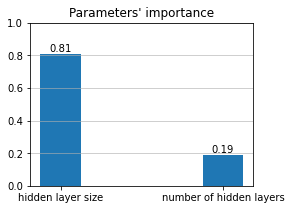

In [32]:
importance = optuna.importance.get_param_importances(study)

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.set_title("Parameters' importance")
bar = ax.bar(importance.keys(), importance.values(), width=0.25)
ax.bar_label(bar, labels=[f"{i:.2f}" for i in importance.values()])
ax.set_ylim(0,1)
ax.grid(axis='y', alpha=0.75)

#### Tuning visualization

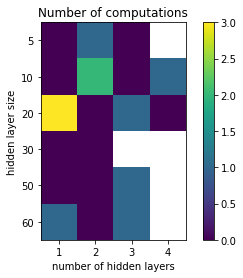

In [71]:
hiddenLayerSizes = [5,10,20,30,50,60]
numbersOfHiddenLayers = [1,2,3,4]

plt.title('Number of computations')

numberOfCompilations = np.full((6,4), np.nan)
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        amount = len(
            trials_df[
            (trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]
        )
        if amount > 0:
            numberOfCompilations[i,j] = len(trials_df[
                (trials_df['state']=='COMPLETE')
                *(trials_df['params_hidden layer size']==hiddenLayerSize)
                *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
                ]
            )
pcol = plt.imshow(numberOfCompilations)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(pcol)

/tmp/ipykernel_2860/1525740979.py:11: RuntimeWarning: Mean of empty slice.
  ]['value'].to_numpy().mean()


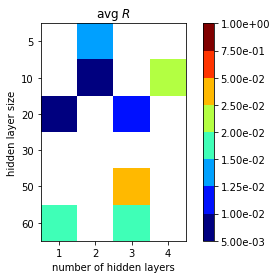

In [73]:
from matplotlib import colors
plt.title(r'avg $R$')

finalResults = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().mean()
bounds = [0.005,0.01,0.0125,0.015,0.02,0.025,0.05,0.75,1]
im = plt.imshow(
    finalResults,
    cmap='jet',
    norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256)
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im, ticks=bounds)
cbar.set_ticklabels([f"{b:.2e}" for b in bounds])

/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/lib/python3/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


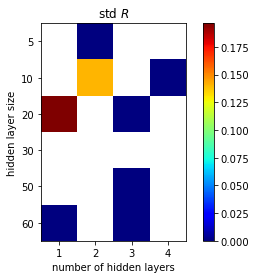

In [74]:
from matplotlib import colors
plt.title(r'std $R$')

finalResults_std = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults_std[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().std() / finalResults[i,j]
im = plt.imshow(
    finalResults_std,
    cmap='jet'
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im)

### std = 0.7

In [20]:
def objective(trial):
    config = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : trial.suggest_categorical("hidden layer size", [5,10,20,30,50,60]),
        "number of hidden layers" : trial.suggest_int("number of hidden layers", 1, 4),
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        'std of initial weights' : 0.7
        
    }
    
    trialFunction = build_and_train_trialFunction(config, trial)

    r, a, b, e, loss = compute_losses_on_uniform_sample(
        trialFunction, 
        config
    )

    return r.cpu().detach().numpy()

#### Optimization

In [30]:
study_name = '3d_std07'
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
    study_name=study_name
)
study.optimize(objective, n_trials=50)
trials_df = study.trials_dataframe()
trials_df.to_csv('../optuna_trials/'+study_name+'.csv')

#### Best trial

In [21]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

hidden layer size: 5
number of hidden layers: 1


#### Parameters' importance

In [25]:
optuna.importance.get_param_importances(study)

{'hidden layer size': 0.5589001314515778,
 'number of hidden layers': 0.44109986854842226}

#### Tuning visualization

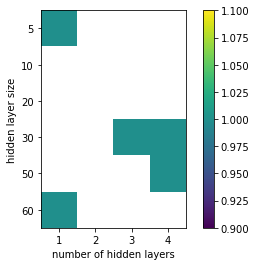

In [33]:
hiddenLayerSizes = [5,10,20,30,50,60]
numbersOfHiddenLayers = [1,2,3,4]

numberOfCompilations = np.full((6,4), np.nan)
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        amount = len(
            trials_df[
            (trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]
        )
        if amount > 0:
            numberOfCompilations[i,j] = len(trials_df[
                (trials_df['state']=='COMPLETE')
                *(trials_df['params_hidden layer size']==hiddenLayerSize)
                *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
                ]
            )
pcol = plt.imshow(numberOfCompilations)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(pcol)

/tmp/ipykernel_24464/2259552634.py:10: RuntimeWarning: Mean of empty slice.
  ]['value'].to_numpy().mean()


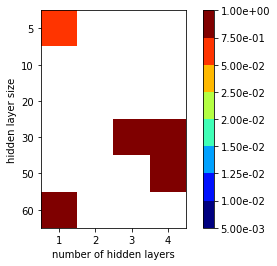

In [34]:
from matplotlib import colors

finalResults = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().mean()
bounds = [0.005,0.01,0.0125,0.015,0.02,0.025,0.05,0.75,1]
im = plt.imshow(
    finalResults,
    cmap='jet',
    norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256)
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im, ticks=bounds)
cbar.set_ticklabels([f"{b:.2e}" for b in bounds])

/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/lib/python3/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


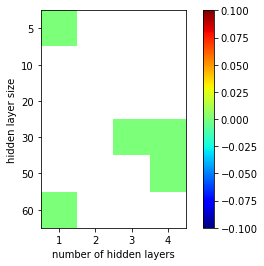

In [35]:
from matplotlib import colors

finalResults_std = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults_std[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().std() / finalResults[i,j]
im = plt.imshow(
    finalResults_std,
    cmap='jet'
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im)

### std = 1.4

In [20]:
def objective(trial):
    config = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : trial.suggest_categorical("hidden layer size", [5,10,20,30,50,60]),
        "number of hidden layers" : trial.suggest_int("number of hidden layers", 1, 4),
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        'std of initial weights' : 1.4
        
    }
    
    trialFunction = build_and_train_trialFunction(config, trial)

    r, a, b, e, loss = compute_losses_on_uniform_sample(
        trialFunction, 
        config
    )

    return r.cpu().detach().numpy()

#### Optimization

In [30]:
study_name = '3d_std1.4'
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
    study_name=study_name
)
study.optimize(objective, n_trials=50)
trials_df = study.trials_dataframe()
trials_df.to_csv('../optuna_trials/'+study_name+'.csv')

#### Best trial

In [21]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

hidden layer size: 5
number of hidden layers: 1


#### Parameters' importance

In [25]:
optuna.importance.get_param_importances(study)

{'hidden layer size': 0.5589001314515778,
 'number of hidden layers': 0.44109986854842226}

#### Tuning visualization

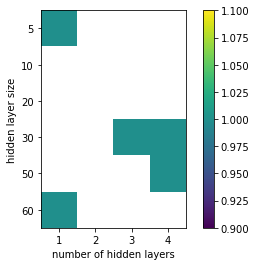

In [33]:
hiddenLayerSizes = [5,10,20,30,50,60]
numbersOfHiddenLayers = [1,2,3,4]

numberOfCompilations = np.full((6,4), np.nan)
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        amount = len(
            trials_df[
            (trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]
        )
        if amount > 0:
            numberOfCompilations[i,j] = len(trials_df[
                (trials_df['state']=='COMPLETE')
                *(trials_df['params_hidden layer size']==hiddenLayerSize)
                *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
                ]
            )
pcol = plt.imshow(numberOfCompilations)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(pcol)

/tmp/ipykernel_24464/2259552634.py:10: RuntimeWarning: Mean of empty slice.
  ]['value'].to_numpy().mean()


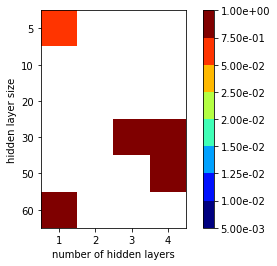

In [34]:
from matplotlib import colors

finalResults = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().mean()
bounds = [0.005,0.01,0.0125,0.015,0.02,0.025,0.05,0.75,1]
im = plt.imshow(
    finalResults,
    cmap='jet',
    norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256)
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im, ticks=bounds)
cbar.set_ticklabels([f"{b:.2e}" for b in bounds])

/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/lib/python3/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


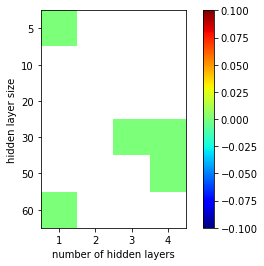

In [35]:
from matplotlib import colors

finalResults_std = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults_std[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().std() / finalResults[i,j]
im = plt.imshow(
    finalResults_std,
    cmap='jet'
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im)

## 4D

### Ordinary case

In [8]:
def objective(trial):
    config = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : trial.suggest_categorical("hidden layer size", [5,10,20,30,50,60]),
        "number of hidden layers" : trial.suggest_int("number of hidden layers", 1, 4),
        "coordinate space dimension" : 4,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        'std of initial weights' : math.sqrt(0.1)
        
    }
    
    trialFunction = build_and_train_trialFunction(config, trial)

    r, a, b, e, loss = compute_losses_on_uniform_sample(
        trialFunction, 
        config
    )

    return r.cpu().detach().numpy()

#### Optimization

In [9]:
study_name = '4d_stdsqrt01'
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
    study_name=study_name
)
study.optimize(objective, n_trials=50)
trials_df = study.trials_dataframe()
trials_df.to_csv('../optuna_trials/'+study_name+'.csv')

[I 2023-10-22 23:57:10,652] A new study created in memory with name: 4d_stdsqrt01


Trial function with name 4d_L10_Nh3_22Oct2023_20:57:11 has been created


[I 2023-10-23 00:25:43,528] Trial 0 finished with value: 0.010740019381046295 and parameters: {'hidden layer size': 10, 'number of hidden layers': 3}. Best is trial 0 with value: 0.010740019381046295.


Trial function with name 4d_L20_Nh1_22Oct2023_21:25:43 has been created


[I 2023-10-23 00:47:06,062] Trial 1 finished with value: 0.0069068437442183495 and parameters: {'hidden layer size': 20, 'number of hidden layers': 1}. Best is trial 1 with value: 0.0069068437442183495.


Trial function with name 4d_L50_Nh1_22Oct2023_21:47:06 has been created


[I 2023-10-23 01:10:51,496] Trial 2 finished with value: 0.007511073257774115 and parameters: {'hidden layer size': 50, 'number of hidden layers': 1}. Best is trial 1 with value: 0.0069068437442183495.


Trial function with name 4d_L10_Nh3_22Oct2023_22:10:51 has been created


[I 2023-10-23 01:39:29,616] Trial 3 finished with value: 0.010142489336431026 and parameters: {'hidden layer size': 10, 'number of hidden layers': 3}. Best is trial 1 with value: 0.0069068437442183495.


Trial function with name 4d_L60_Nh2_22Oct2023_22:39:29 has been created


[I 2023-10-23 02:11:18,301] Trial 4 finished with value: 0.018647395074367523 and parameters: {'hidden layer size': 60, 'number of hidden layers': 2}. Best is trial 1 with value: 0.0069068437442183495.


Trial function with name 4d_L10_Nh1_22Oct2023_23:11:18 has been created


[I 2023-10-23 02:29:33,568] Trial 5 finished with value: 0.006485491059720516 and parameters: {'hidden layer size': 10, 'number of hidden layers': 1}. Best is trial 5 with value: 0.006485491059720516.


Trial function with name 4d_L30_Nh1_22Oct2023_23:29:33 has been created


[I 2023-10-23 02:36:58,360] Trial 6 pruned. 


Trial function with name 4d_L20_Nh1_22Oct2023_23:36:58 has been created


[I 2023-10-23 02:36:58,685] Trial 7 pruned. 


Trial function with name 4d_L5_Nh1_22Oct2023_23:36:58 has been created


[I 2023-10-23 02:36:58,999] Trial 8 pruned. 


Trial function with name 4d_L10_Nh4_22Oct2023_23:36:58 has been created


[I 2023-10-23 02:48:10,748] Trial 9 pruned. 


Trial function with name 4d_L5_Nh2_22Oct2023_23:48:10 has been created


[I 2023-10-23 02:55:41,643] Trial 10 pruned. 


Trial function with name 4d_L20_Nh2_22Oct2023_23:55:41 has been created


[I 2023-10-23 02:55:41,990] Trial 11 pruned. 


Trial function with name 4d_L20_Nh1_22Oct2023_23:55:41 has been created


[I 2023-10-23 03:16:52,119] Trial 12 finished with value: 0.00927575584501028 and parameters: {'hidden layer size': 20, 'number of hidden layers': 1}. Best is trial 5 with value: 0.006485491059720516.


Trial function with name 4d_L30_Nh2_23Oct2023_00:16:52 has been created


[I 2023-10-23 03:16:52,463] Trial 13 pruned. 


Trial function with name 4d_L60_Nh4_23Oct2023_00:16:52 has been created


[I 2023-10-23 03:16:53,077] Trial 14 pruned. 


Trial function with name 4d_L50_Nh1_23Oct2023_00:16:53 has been created


[I 2023-10-23 03:16:53,424] Trial 15 pruned. 


Trial function with name 4d_L20_Nh3_23Oct2023_00:16:53 has been created


[I 2023-10-23 03:16:53,793] Trial 16 pruned. 


Trial function with name 4d_L10_Nh2_23Oct2023_00:16:53 has been created


[I 2023-10-23 03:16:54,125] Trial 17 pruned. 


Trial function with name 4d_L10_Nh1_23Oct2023_00:16:54 has been created


[I 2023-10-23 03:16:54,434] Trial 18 pruned. 


Trial function with name 4d_L20_Nh2_23Oct2023_00:16:54 has been created


[I 2023-10-23 03:16:54,787] Trial 19 pruned. 


Trial function with name 4d_L50_Nh1_23Oct2023_00:16:54 has been created


[I 2023-10-23 03:16:55,123] Trial 20 pruned. 


Trial function with name 4d_L50_Nh1_23Oct2023_00:16:55 has been created


[I 2023-10-23 03:16:55,446] Trial 21 pruned. 


Trial function with name 4d_L50_Nh1_23Oct2023_00:16:55 has been created


[I 2023-10-23 03:16:55,775] Trial 22 pruned. 


Trial function with name 4d_L50_Nh1_23Oct2023_00:16:55 has been created


[I 2023-10-23 03:16:56,099] Trial 23 pruned. 


Trial function with name 4d_L30_Nh2_23Oct2023_00:16:56 has been created


[I 2023-10-23 03:16:56,447] Trial 24 pruned. 


Trial function with name 4d_L60_Nh1_23Oct2023_00:16:56 has been created


[I 2023-10-23 03:16:56,770] Trial 25 pruned. 


Trial function with name 4d_L50_Nh2_23Oct2023_00:16:56 has been created


[I 2023-10-23 03:16:57,131] Trial 26 pruned. 


Trial function with name 4d_L5_Nh1_23Oct2023_00:16:57 has been created


[I 2023-10-23 03:34:31,224] Trial 27 finished with value: 0.004869174677878618 and parameters: {'hidden layer size': 5, 'number of hidden layers': 1}. Best is trial 27 with value: 0.004869174677878618.


Trial function with name 4d_L5_Nh3_23Oct2023_00:34:31 has been created


[I 2023-10-23 03:43:48,444] Trial 28 pruned. 


Trial function with name 4d_L5_Nh1_23Oct2023_00:43:48 has been created


[I 2023-10-23 04:01:34,015] Trial 29 finished with value: 0.0069685084745287895 and parameters: {'hidden layer size': 5, 'number of hidden layers': 1}. Best is trial 27 with value: 0.004869174677878618.


Trial function with name 4d_L5_Nh2_23Oct2023_01:01:34 has been created


[I 2023-10-23 04:09:14,582] Trial 30 pruned. 


Trial function with name 4d_L5_Nh1_23Oct2023_01:09:14 has been created


[I 2023-10-23 04:27:05,845] Trial 31 finished with value: 0.005843439605087042 and parameters: {'hidden layer size': 5, 'number of hidden layers': 1}. Best is trial 27 with value: 0.004869174677878618.


Trial function with name 4d_L5_Nh1_23Oct2023_01:27:05 has been created


[I 2023-10-23 04:27:06,144] Trial 32 pruned. 


Trial function with name 4d_L10_Nh1_23Oct2023_01:27:06 has been created


[I 2023-10-23 04:27:06,447] Trial 33 pruned. 


Trial function with name 4d_L5_Nh1_23Oct2023_01:27:06 has been created


[I 2023-10-23 04:45:03,018] Trial 34 finished with value: 0.004931292496621609 and parameters: {'hidden layer size': 5, 'number of hidden layers': 1}. Best is trial 27 with value: 0.004869174677878618.


Trial function with name 4d_L5_Nh1_23Oct2023_01:45:03 has been created


[I 2023-10-23 04:45:03,324] Trial 35 pruned. 


Trial function with name 4d_L5_Nh1_23Oct2023_01:45:03 has been created


[I 2023-10-23 04:45:03,633] Trial 36 pruned. 


Trial function with name 4d_L5_Nh2_23Oct2023_01:45:03 has been created


[I 2023-10-23 05:08:03,087] Trial 37 finished with value: 0.00602704705670476 and parameters: {'hidden layer size': 5, 'number of hidden layers': 2}. Best is trial 27 with value: 0.004869174677878618.


Trial function with name 4d_L5_Nh3_23Oct2023_02:08:03 has been created


[I 2023-10-23 05:08:03,419] Trial 38 pruned. 


Trial function with name 4d_L5_Nh2_23Oct2023_02:08:03 has been created


[I 2023-10-23 05:08:03,738] Trial 39 pruned. 


Trial function with name 4d_L5_Nh2_23Oct2023_02:08:03 has been created


[I 2023-10-23 05:08:04,072] Trial 40 pruned. 


Trial function with name 4d_L5_Nh1_23Oct2023_02:08:04 has been created


[I 2023-10-23 05:26:00,260] Trial 41 finished with value: 0.005174074321985245 and parameters: {'hidden layer size': 5, 'number of hidden layers': 1}. Best is trial 27 with value: 0.004869174677878618.


Trial function with name 4d_L5_Nh1_23Oct2023_02:26:00 has been created


[I 2023-10-23 05:26:00,570] Trial 42 pruned. 


Trial function with name 4d_L5_Nh1_23Oct2023_02:26:00 has been created


[I 2023-10-23 05:26:00,886] Trial 43 pruned. 


Trial function with name 4d_L5_Nh1_23Oct2023_02:26:00 has been created


[I 2023-10-23 05:26:01,197] Trial 44 pruned. 


Trial function with name 4d_L5_Nh4_23Oct2023_02:26:01 has been created


[I 2023-10-23 05:37:04,038] Trial 45 pruned. 


Trial function with name 4d_L5_Nh2_23Oct2023_02:37:04 has been created


[I 2023-10-23 05:44:31,073] Trial 46 pruned. 


Trial function with name 4d_L5_Nh1_23Oct2023_02:44:31 has been created


[I 2023-10-23 06:01:59,758] Trial 47 finished with value: 0.00468329107388854 and parameters: {'hidden layer size': 5, 'number of hidden layers': 1}. Best is trial 47 with value: 0.00468329107388854.


Trial function with name 4d_L60_Nh1_23Oct2023_03:01:59 has been created


[I 2023-10-23 06:02:00,110] Trial 48 pruned. 


Trial function with name 4d_L30_Nh1_23Oct2023_03:02:00 has been created


[I 2023-10-23 06:02:00,430] Trial 49 pruned. 


In [33]:
print("It lasted from "
      +str(trials_df['datetime_start'][0])
      +" to "
      +str(trials_df['datetime_complete'][49])
     )

It lasted from 2023-10-22 23:57:10.654010 to 2023-10-23 06:02:00.430072


#### Best trial

In [34]:
best_trial = study.best_trial
print("Best trial:")
for key, value in best_trial.params.items():
    print("{} is {}".format(key, value))

Best trial:
hidden layer size is 5
number of hidden layers is 1


#### Parameters' importance

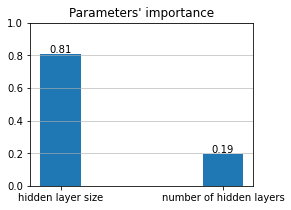

In [35]:
importance = optuna.importance.get_param_importances(study)

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.set_title("Parameters' importance")
bar = ax.bar(importance.keys(), importance.values(), width=0.25)
ax.bar_label(bar, labels=[f"{i:.2f}" for i in importance.values()])
ax.set_ylim(0,1)
ax.grid(axis='y', alpha=0.75)

#### Tuning visualization

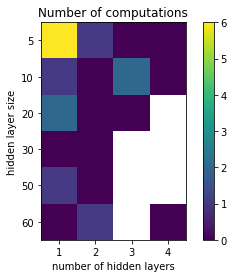

In [17]:
hiddenLayerSizes = [5,10,20,30,50,60]
numbersOfHiddenLayers = [1,2,3,4]

plt.title('Number of computations')

numberOfCompilations = np.full((6,4), np.nan)
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        amount = len(
            trials_df[
            (trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]
        )
        if amount > 0:
            numberOfCompilations[i,j] = len(trials_df[
                (trials_df['state']=='COMPLETE')
                *(trials_df['params_hidden layer size']==hiddenLayerSize)
                *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
                ]
            )
pcol = plt.imshow(numberOfCompilations)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(pcol)

/tmp/ipykernel_483/1525740979.py:11: RuntimeWarning: Mean of empty slice.
  ]['value'].to_numpy().mean()
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


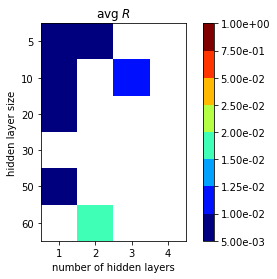

In [18]:
from matplotlib import colors
plt.title(r'avg $R$')

finalResults = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().mean()
bounds = [0.005,0.01,0.0125,0.015,0.02,0.025,0.05,0.75,1]
im = plt.imshow(
    finalResults,
    cmap='jet',
    norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256)
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im, ticks=bounds)
cbar.set_ticklabels([f"{b:.2e}" for b in bounds])

/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/lib/python3/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


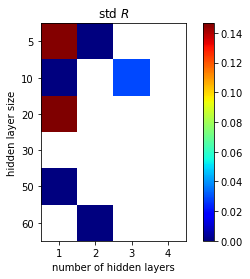

In [19]:
from matplotlib import colors
plt.title(r'std $R$')

finalResults_std = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults_std[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().std() / finalResults[i,j]
im = plt.imshow(
    finalResults_std,
    cmap='jet'
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im)

## 5D

### Ordinary case

In [8]:
def objective(trial):
    config = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : trial.suggest_categorical("hidden layer size", [5,10,20,30,50,60]),
        "number of hidden layers" : trial.suggest_int("number of hidden layers", 1, 4),
        "coordinate space dimension" : 5,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        'std of initial weights' : math.sqrt(0.1)
        
    }
    
    trialFunction = build_and_train_trialFunction(config, trial)

    r, a, b, e, loss = compute_losses_on_uniform_sample(
        trialFunction, 
        config
    )

    return r.cpu().detach().numpy()

#### Optimization

In [9]:
study_name = '5d_stdsqrt01'
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
    study_name=study_name
)
study.optimize(objective, n_trials=50)
trials_df = study.trials_dataframe()
trials_df.to_csv('../optuna_trials/'+study_name+'.csv')

[I 2023-10-23 08:45:53,376] A new study created in memory with name: 5d_stdsqrt01


Trial function with name 5d_L30_Nh2_23Oct2023_05:45:53 has been created


[I 2023-10-23 09:19:05,267] Trial 0 finished with value: 0.015621996484696865 and parameters: {'hidden layer size': 30, 'number of hidden layers': 2}. Best is trial 0 with value: 0.015621996484696865.


Trial function with name 5d_L5_Nh3_23Oct2023_06:19:05 has been created


[I 2023-10-23 09:53:59,778] Trial 1 finished with value: 0.011125951074063778 and parameters: {'hidden layer size': 5, 'number of hidden layers': 3}. Best is trial 1 with value: 0.011125951074063778.


Trial function with name 5d_L30_Nh4_23Oct2023_06:53:59 has been created


[I 2023-10-23 10:42:18,595] Trial 2 finished with value: 0.02237970568239689 and parameters: {'hidden layer size': 30, 'number of hidden layers': 4}. Best is trial 1 with value: 0.011125951074063778.


Trial function with name 5d_L50_Nh3_23Oct2023_07:42:18 has been created


[I 2023-10-23 18:37:18,719] Trial 3 finished with value: 0.021583272144198418 and parameters: {'hidden layer size': 50, 'number of hidden layers': 3}. Best is trial 1 with value: 0.011125951074063778.


Trial function with name 5d_L10_Nh1_23Oct2023_15:37:18 has been created


[I 2023-10-23 19:00:07,335] Trial 4 finished with value: 0.005985731724649668 and parameters: {'hidden layer size': 10, 'number of hidden layers': 1}. Best is trial 4 with value: 0.005985731724649668.


Trial function with name 5d_L20_Nh4_23Oct2023_16:00:07 has been created


[I 2023-10-23 19:15:52,208] Trial 5 pruned. 


Trial function with name 5d_L5_Nh2_23Oct2023_16:15:52 has been created


[I 2023-10-23 19:44:36,168] Trial 6 finished with value: 0.008493514731526375 and parameters: {'hidden layer size': 5, 'number of hidden layers': 2}. Best is trial 4 with value: 0.005985731724649668.


Trial function with name 5d_L50_Nh3_23Oct2023_16:44:36 has been created


[I 2023-10-23 19:44:38,897] Trial 7 pruned. 


Trial function with name 5d_L30_Nh1_23Oct2023_16:44:38 has been created


[I 2023-10-23 20:10:37,092] Trial 8 finished with value: 0.009740149602293968 and parameters: {'hidden layer size': 30, 'number of hidden layers': 1}. Best is trial 4 with value: 0.005985731724649668.


Trial function with name 5d_L5_Nh4_23Oct2023_17:10:37 has been created


[I 2023-10-23 20:39:15,494] Trial 9 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_17:39:15 has been created


[I 2023-10-23 21:02:09,613] Trial 10 finished with value: 0.005494934506714344 and parameters: {'hidden layer size': 10, 'number of hidden layers': 1}. Best is trial 10 with value: 0.005494934506714344.


Trial function with name 5d_L10_Nh1_23Oct2023_18:02:09 has been created


[I 2023-10-23 21:24:55,721] Trial 11 finished with value: 0.0061448016203939915 and parameters: {'hidden layer size': 10, 'number of hidden layers': 1}. Best is trial 10 with value: 0.005494934506714344.


Trial function with name 5d_L10_Nh1_23Oct2023_18:24:55 has been created


[I 2023-10-23 21:47:39,093] Trial 12 finished with value: 0.007348720915615559 and parameters: {'hidden layer size': 10, 'number of hidden layers': 1}. Best is trial 10 with value: 0.005494934506714344.


Trial function with name 5d_L60_Nh2_23Oct2023_18:47:39 has been created


[I 2023-10-23 21:47:40,977] Trial 13 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_18:47:40 has been created


[I 2023-10-23 21:47:41,325] Trial 14 pruned. 


Trial function with name 5d_L10_Nh2_23Oct2023_18:47:41 has been created


[I 2023-10-23 21:47:41,741] Trial 15 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_18:47:41 has been created


[I 2023-10-23 21:47:42,098] Trial 16 pruned. 


Trial function with name 5d_L20_Nh1_23Oct2023_18:47:42 has been created


[I 2023-10-23 21:47:42,513] Trial 17 pruned. 


Trial function with name 5d_L60_Nh2_23Oct2023_18:47:42 has been created


[I 2023-10-23 21:47:44,395] Trial 18 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_18:47:44 has been created


[I 2023-10-23 21:47:44,740] Trial 19 pruned. 


Trial function with name 5d_L10_Nh2_23Oct2023_18:47:44 has been created


[I 2023-10-23 21:47:45,119] Trial 20 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_18:47:45 has been created


[I 2023-10-23 21:47:45,484] Trial 21 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_18:47:45 has been created


[I 2023-10-23 21:47:45,884] Trial 22 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_18:47:45 has been created


[I 2023-10-23 22:09:10,971] Trial 23 finished with value: 0.004796793218702078 and parameters: {'hidden layer size': 10, 'number of hidden layers': 1}. Best is trial 23 with value: 0.004796793218702078.


Trial function with name 5d_L10_Nh1_23Oct2023_19:09:10 has been created


[I 2023-10-23 22:09:11,311] Trial 24 pruned. 


Trial function with name 5d_L10_Nh2_23Oct2023_19:09:11 has been created


[I 2023-10-23 22:09:11,677] Trial 25 pruned. 


Trial function with name 5d_L60_Nh1_23Oct2023_19:09:11 has been created


[I 2023-10-23 22:09:12,355] Trial 26 pruned. 


Trial function with name 5d_L50_Nh2_23Oct2023_19:09:12 has been created


[I 2023-10-23 22:09:13,919] Trial 27 pruned. 


Trial function with name 5d_L20_Nh1_23Oct2023_19:09:13 has been created


[I 2023-10-23 22:09:14,260] Trial 28 pruned. 


Trial function with name 5d_L30_Nh3_23Oct2023_19:09:14 has been created


[I 2023-10-23 22:09:14,690] Trial 29 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_19:09:14 has been created


[I 2023-10-23 22:30:00,970] Trial 30 finished with value: 0.007010016590356827 and parameters: {'hidden layer size': 10, 'number of hidden layers': 1}. Best is trial 23 with value: 0.004796793218702078.


Trial function with name 5d_L10_Nh1_23Oct2023_19:30:00 has been created


[I 2023-10-23 22:30:01,304] Trial 31 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_19:30:01 has been created


[I 2023-10-23 22:30:01,665] Trial 32 pruned. 


Trial function with name 5d_L10_Nh2_23Oct2023_19:30:01 has been created


[I 2023-10-23 22:30:02,034] Trial 33 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_19:30:02 has been created


[I 2023-10-23 22:43:51,213] Trial 34 pruned. 


Trial function with name 5d_L5_Nh1_23Oct2023_19:43:51 has been created


[I 2023-10-23 23:04:56,737] Trial 35 finished with value: 0.0041532861068844795 and parameters: {'hidden layer size': 5, 'number of hidden layers': 1}. Best is trial 35 with value: 0.0041532861068844795.


Trial function with name 5d_L5_Nh2_23Oct2023_20:04:56 has been created


[I 2023-10-23 23:13:38,274] Trial 36 pruned. 


Trial function with name 5d_L5_Nh1_23Oct2023_20:13:38 has been created


[I 2023-10-23 23:13:38,622] Trial 37 pruned. 


Trial function with name 5d_L5_Nh2_23Oct2023_20:13:38 has been created


[I 2023-10-23 23:13:38,985] Trial 38 pruned. 


Trial function with name 5d_L5_Nh4_23Oct2023_20:13:38 has been created


[I 2023-10-23 23:27:09,306] Trial 39 pruned. 


Trial function with name 5d_L50_Nh1_23Oct2023_20:27:09 has been created


[I 2023-10-23 23:27:09,990] Trial 40 pruned. 


Trial function with name 5d_L30_Nh1_23Oct2023_20:27:09 has been created


[I 2023-10-23 23:27:10,315] Trial 41 pruned. 


Trial function with name 5d_L5_Nh1_23Oct2023_20:27:10 has been created


[I 2023-10-23 23:27:10,655] Trial 42 pruned. 


Trial function with name 5d_L20_Nh1_23Oct2023_20:27:10 has been created


[I 2023-10-23 23:27:11,007] Trial 43 pruned. 


Trial function with name 5d_L10_Nh1_23Oct2023_20:27:11 has been created


[I 2023-10-23 23:27:11,315] Trial 44 pruned. 


Trial function with name 5d_L10_Nh3_23Oct2023_20:27:11 has been created


[I 2023-10-23 23:27:11,787] Trial 45 pruned. 


Trial function with name 5d_L50_Nh1_23Oct2023_20:27:11 has been created


[I 2023-10-23 23:27:12,449] Trial 46 pruned. 


Trial function with name 5d_L60_Nh1_23Oct2023_20:27:12 has been created


[I 2023-10-23 23:27:13,145] Trial 47 pruned. 


Trial function with name 5d_L30_Nh1_23Oct2023_20:27:13 has been created


[I 2023-10-23 23:27:13,487] Trial 48 pruned. 


Trial function with name 5d_L5_Nh2_23Oct2023_20:27:13 has been created


[I 2023-10-23 23:27:13,881] Trial 49 pruned. 


In [16]:
print("It lasted from "
      +str(trials_df['datetime_start'][0])
      +" to "
      +str(trials_df['datetime_complete'][49])
     )

It lasted from 2023-10-23 08:45:53.378449 to 2023-10-23 23:27:13.881324


#### Best trial

In [17]:
best_trial = study.best_trial
print("Best trial:")
for key, value in best_trial.params.items():
    print("{} is {}".format(key, value))

Best trial:
hidden layer size is 5
number of hidden layers is 1


#### Parameters' importance

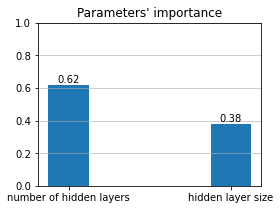

In [20]:
importance = optuna.importance.get_param_importances(study)

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.set_title("Parameters' importance")
bar = ax.bar(importance.keys(), importance.values(), width=0.25)
ax.bar_label(bar, labels=[f"{i:.2f}" for i in importance.values()])
ax.set_ylim(0,1)
ax.grid(axis='y', alpha=0.75)

#### Tuning visualization

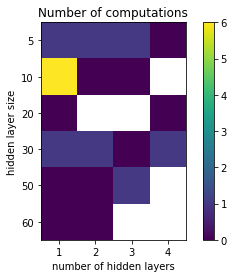

In [21]:
hiddenLayerSizes = [5,10,20,30,50,60]
numbersOfHiddenLayers = [1,2,3,4]

plt.title('Number of computations')

numberOfCompilations = np.full((6,4), np.nan)
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        amount = len(
            trials_df[
            (trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]
        )
        if amount > 0:
            numberOfCompilations[i,j] = len(trials_df[
                (trials_df['state']=='COMPLETE')
                *(trials_df['params_hidden layer size']==hiddenLayerSize)
                *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
                ]
            )
pcol = plt.imshow(numberOfCompilations)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(pcol)

/tmp/ipykernel_4500/1525740979.py:11: RuntimeWarning: Mean of empty slice.
  ]['value'].to_numpy().mean()
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


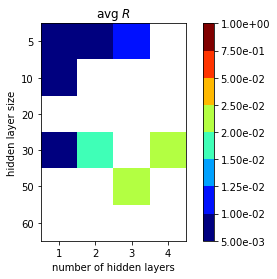

In [22]:
from matplotlib import colors
plt.title(r'avg $R$')

finalResults = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().mean()
bounds = [0.005,0.01,0.0125,0.015,0.02,0.025,0.05,0.75,1]
im = plt.imshow(
    finalResults,
    cmap='jet',
    norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256)
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im, ticks=bounds)
cbar.set_ticklabels([f"{b:.2e}" for b in bounds])

/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/lib/python3/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


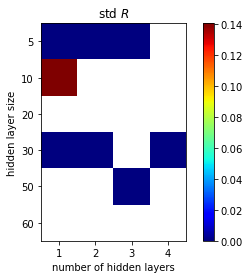

In [23]:
from matplotlib import colors
plt.title(r'std $R$')

finalResults_std = np.zeros((6,4))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults_std[i,j] = trials_df[
            (trials_df['state']=='COMPLETE')
            *(trials_df['params_hidden layer size']==hiddenLayerSize)
            *(trials_df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().std() / finalResults[i,j]
im = plt.imshow(
    finalResults_std,
    cmap='jet'
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im)

# Visualisation

In [15]:
trials_df[
    (trials_df['state']=='COMPLETE')
    *(trials_df['params_hidden layer size']==20)
    *(trials_df['params_number of hidden layers']==1)
]

NameError: name 'trials_df' is not defined

In [25]:
ls ../models/5d_L5_Nh1*

../models/5d_L5_Nh1_23Oct2023_19:43:51.pt


In [30]:
name = "L60_Nh2_06Nov2023_21:57:58"

trialFunction_3D = TrialFunction(
    {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 60,
        "number of hidden layers" : 2,
        "coordinate space dimension" : 3,
        "number of states" : 35,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    },
    "3d_"+name
)
trialFunction_3D.load_state_dict(torch.load(trialFunction_3D.PATH))
trialFunction_3D.eval()

Trial function with name 3d_L60_Nh2_06Nov2023_21:57:58 has been created


TrialFunction(
  (neuralNetwork): NeuralNetwork(
    (activationFunction): CustomSin()
    (stack): Sequential(
      (0): Linear(in_features=3, out_features=60, bias=True)
      (1): CustomSin()
      (2): Linear(in_features=60, out_features=60, bias=True)
      (3): CustomSin()
      (4): Linear(in_features=60, out_features=35, bias=True)
      (5): CustomSin()
    )
  )
  (amplitudeFunction): Gaussian()
)

In [31]:
timeHistory_1 = pd.read_csv("../loss/time_3d_"+name+".csv")
lossHistory_1 = pd.read_csv("../loss/loss_3d_"+name+".csv")
eHistory_1 = pd.read_csv("../loss/e_3d_"+name+".csv")

In [32]:
lossHistory_1[-1:]

,Unnamed: 0,total loss,total squered residual,total normalisation error,total orthogonalisation error
100,100,915.107178,288.768555,5.770689,10.838791


In [33]:
eHistory_1[-1:]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
100,100,5.822076,4.632104,7.338086,8.35717,4.073658,5.832164,9.042204,4.710457,7.531586,...,5.379916,5.584517,4.807937,4.637881,4.589027,4.282344,4.607299,5.433528,6.079204,7.778905


Text(0.5, 0, 'Iteration number')

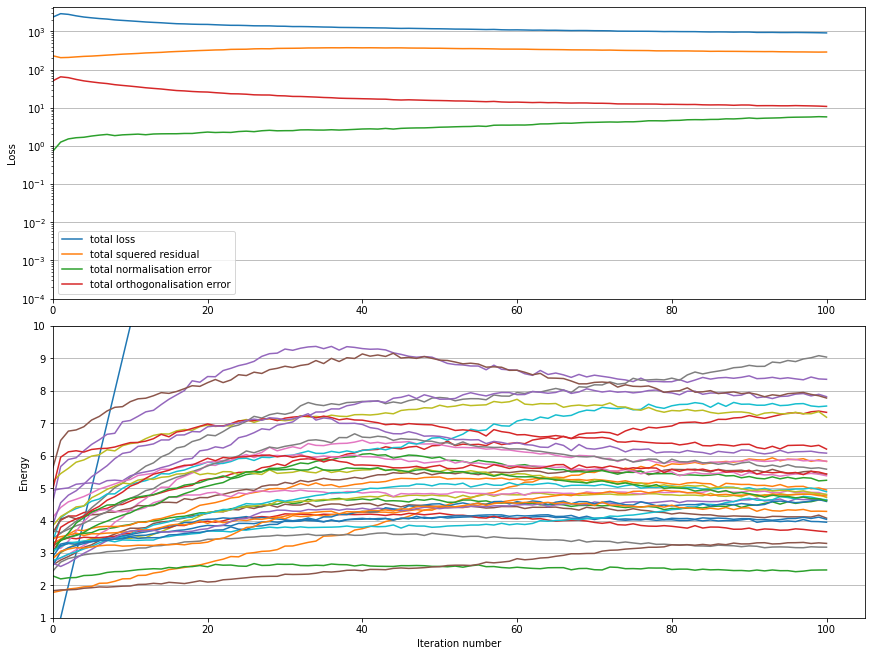

In [34]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(12,9), layout='constrained')
lossHistory_1[[
    'total loss', 
    'total squered residual', 
    'total normalisation error',
    'total orthogonalisation error'
]].plot(ax=ax)
ax.set_yscale('log')
ax.grid(axis='y')
ax.set_ylim(1e-4,None)
ax.set_xlim(0,None)
ax.set_ylabel('Loss')
# plt.xlabel('Iteration number')

eHistory_1.plot(ax=ax1,legend=False)
# ax.set_yscale('log')
ax1.grid(axis='y')
ax1.set_ylim(1,10)
ax1.set_xlim(0,None)
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration number')

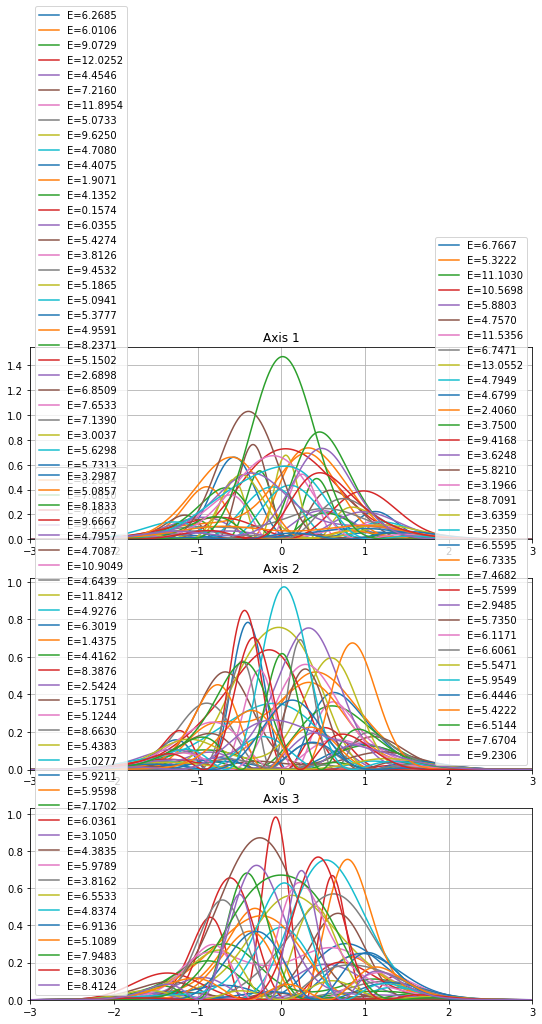

In [35]:
D = 3
fig, axes = plt.subplots(
    D,1,
    figsize=(9*1,12),
    squeeze=False
)
for axNumber, ax in enumerate(axes[:,0]):
    grid = torch.zeros(
        (1000,D),
        device="cuda"
    )
    grid[:,axNumber] = torch.linspace(-3,3,1000,device='cuda')
    # ax.plot(
    #     grid[:,axNumber].cpu().detach().numpy(),
    #     trialFunction_3D.weightFunction(grid).cpu().detach().numpy()
    # )
    for i in range(35):
        ax.plot(
            grid[:,axNumber].cpu().detach().numpy(), 
            (
                trialFunction_3D(grid)[:,i].cpu().detach().numpy()**2
                / trialFunction_3D.norm(grid)[i].cpu().detach().numpy()
            ),
            label=f'E={trialFunction_3D.spectrum(grid,False)[i]:.4f}'
        )
    ax.set_title(f"Axis {axNumber+1}")
    ax.legend()
    ax.set_xlim(-3,3)
    ax.set_ylim(0,None)
    ax.grid()

0
1
2


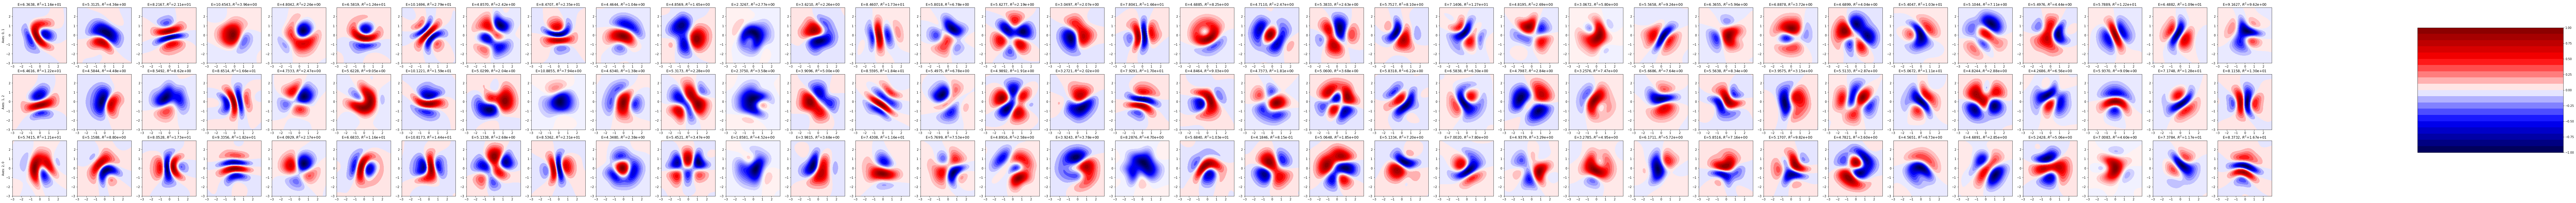

In [36]:
D = 3
fig, axes = plt.subplots(
    D,35,
    figsize=(4*35,D*4),
    squeeze=False
)
for axNumber in range(D):
    print(axNumber)
    grid = torch.zeros(
        (10000,D),
        device="cuda"
    )
    for ix in range(100):
        for iy in range(100):
            grid[ix*100+iy,axNumber%D] = -3 + 6 * ix / 100
            grid[ix*100+iy,(axNumber+1)%D] = -3 + 6 * iy / 100
    e = trialFunction_3D.spectrum(grid, False)
    r2 = trialFunction_3D.squeredResidual(grid, False)
    wf = trialFunction_3D(grid)
    for i in range(35):
        if i != 4:
            pcmesh = axes[axNumber,i].contourf(
            -3 + 6 * np.arange(100) / 100,
            -3 + 6 * np.arange(100) / 100, 
            (wf[:,i] / torch.max(torch.abs(wf[:,i]))).cpu().detach().numpy().reshape(100,100),
            cmap='seismic',
            vmin=-1, vmax=1,
            levels=20
            )
        else:
            axes[axNumber,i].contourf(
            -3 + 6 * np.arange(100) / 100,
            -3 + 6 * np.arange(100) / 100, 
            (wf[:,i] / torch.max(torch.abs(wf[:,i]))).cpu().detach().numpy().reshape(100,100),
            cmap='seismic',
            vmin=-1, vmax=1,
            levels=20
            )
        axes[axNumber,i].set_title(fr'E={e[i]:.4f}, $R^2$={r2[i]:.2e}')
    axes[axNumber,0].set_ylabel(f"Axes: {axNumber%D}, {(axNumber+1)%D}")
    # ax.set_title()
    # axes.legend()
    # ax.set_xlim(-3,3)
    # ax.set_ylim(0,None)
    # axes.grid()
# fig.adjust_subplots(hspace=0.2)
cax = plt.axes((0.95, 0.3, 0.05, 0.5))
fig.colorbar(pcmesh, cax=cax, orientation='vertical', ticks=np.arange(-1,1+0.1,0.25))

In [162]:
def energiesForDirection(
    trialFunction: TrialFunction, 
    direction: torch.Tensor
) -> torch.Tensor:
    D = len(direction)
    L = 3
    N = 1000
    delta = 2*L / (N-1)
    sample = torch.empty((N,D), device='cuda')
    n = direction / direction.norm()
    for i in range(N):
        sample[i] = n * (
            -L + delta * i
        )
    forward = trialFunction(sample)
    M = forward.shape[1]
    result = torch.empty(M, device='cuda')
    for m in range(M):
        laplacian = torch.zeros((N), device='cuda')
        laplacian[1:-1] = (
            forward[:-2,m] - 2*forward[1:-1,m] + forward[2:,m]
        ) / delta**2
        
        result[m] = torch.mean(
            (
                -0.5 * laplacian 
                + 0.5 * (sample**2).sum(axis=1) * forward[:,m]
            ) / forward[:,m]
        )# / torch.mean(forward[:,m]**2)
    return result

In [184]:
def objectiveAA(trial):
    alpha1 = trial.suggest_float('alpha1', 0, np.pi)
    alpha2 = trial.suggest_float('alpha2', 0, np.pi)
    alpha3 = trial.suggest_float('alpha3', 0, np.pi)
    BAD_ = 999.0
    if (np.cos(alpha3)**2+np.cos(alpha2)**2+np.cos(alpha1)**2 > 1):
        return BAD_
    else:
        alpha4 = np.arccos(np.sqrt(1 - (np.cos(alpha3)**2+np.cos(alpha2)**2+np.cos(alpha1)**2)))
        direction = torch.tensor(
            [
                np.cos(alpha1),
                np.cos(alpha2),
                np.cos(alpha3),
                np.cos(alpha4),
            ]
        )
        es = energiesForDirection(trialFunction_3D, direction)
        if min(es) < 0:
            return BAD_
        else:
            return (es.cpu().detach().numpy().sum() - 3)**2

studyAA_name = 'test'
studyAA = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    study_name=studyAA_name
)
studyAA.optimize(objectiveAA, n_trials=100)

[I 2023-10-23 08:42:03,929] A new study created in memory with name: test
[I 2023-10-23 08:42:03,931] Trial 0 finished with value: 999.0 and parameters: {'alpha1': 0.5195930284108484, 'alpha2': 1.0763611230419357, 'alpha3': 2.3997141120766807}. Best is trial 0 with value: 999.0.
[I 2023-10-23 08:42:03,932] Trial 1 finished with value: 999.0 and parameters: {'alpha1': 0.5410604580438381, 'alpha2': 1.0883553879770604, 'alpha3': 1.9558291477193808}. Best is trial 0 with value: 999.0.
[I 2023-10-23 08:42:03,933] Trial 2 finished with value: 999.0 and parameters: {'alpha1': 0.45522323814312965, 'alpha2': 1.576072441073967, 'alpha3': 0.6534591782727384}. Best is trial 0 with value: 999.0.
[I 2023-10-23 08:42:03,934] Trial 3 finished with value: 999.0 and parameters: {'alpha1': 0.3734033867000089, 'alpha2': 1.6962217892322142, 'alpha3': 2.4687009918220575}. Best is trial 0 with value: 999.0.
[I 2023-10-23 08:42:03,935] Trial 4 finished with value: 999.0 and parameters: {'alpha1': 0.4885359130

In [185]:
best_trial = studyAA.best_trial
alpha = list(best_trial.params.values())
alpha4 = np.arccos(
    np.sqrt(
        1 - (
    np.cos(alpha[0])**2
    +np.cos(alpha[1])**2
    +np.cos(alpha[2])**2
        )
    )
)
alpha.append(alpha4)
print(alpha)

[2.0661939997542236, 1.6443897606199092, 1.6885115256240375, 0.518022935999277]


In [186]:
direction = torch.tensor([
    np.cos(alpha[0]),
    np.cos(alpha[1]),
    np.cos(alpha[2]),
    np.cos(alpha[3]),
])
es = energiesForDirection(trialFunction_3D, direction)
es

tensor([0.5866, 1.4679, 1.3223, 1.4773, 0.4878], device='cuda:0',
       grad_fn=<CopySlices>)